## Comparing timeseries of observational data

In [1]:
import xarray as xr
from datatree import DataTree
import matplotlib.pyplot as plt
import os
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.processing.select import select_point, get_shapefile_mask
from valenspy.diagnostic.functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score, time_series_spatial_mean, calc_metrics_dt, calc_metrics_da,_add_ranks_metrics, root_mean_square_error
from valenspy.diagnostic.visualizations import plot_time_series, plot_map, plot_metric_ranking
from pathlib import Path
import pandas as pd
import numpy as np
import xoak
from sklearn.neighbors import BallTree as skBallTree
from scipy.stats import pearsonr

from functions import point_data_2_climate_grid

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)

In [2]:
metrics = ["rmse", "mean_bias", "pearson_correlation2", "mean_absolute_error", "spearman_correlation"]
start_date = "2019-07-25 00:00:00"
end_date = "2019-07-25 23:59:59" 
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
start_date_hw = "2019-07-25 00:00:00"
end_date_hw = "2019-07-25 23:59:59" 

start_date_hw = pd.to_datetime(start_date_hw)
end_date_hw = pd.to_datetime(end_date_hw)

### 1. Getting model data

In [3]:
file_wrf = "/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/UCL/geo_em.d03_new.nc"
ds = xr.open_mfdataset(file_wrf, combine='by_coords')
ds = ds.assign_coords({"lat":ds.CLAT})
ds = ds.assign_coords({"lon":ds.CLONG})


### 2. Loading Observation Data + Converting to right format

In [4]:
ucl_dir = "/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/UCL/"

In [5]:
obs_data_str = "wow"
# Loading data
wow_file = ucl_dir + "wow_qc_BE.csv"
orig_data = pd.read_csv(wow_file)
orig_data = orig_data.loc[np.where(orig_data.m4)]
obs_data = orig_data[["p_id", "lon", "lat", "time", "ta"]]
obs_data = obs_data.rename(columns = {"ta" : "T2"})
obs_data["code"] = obs_data["lat"].astype(str) + '-' + obs_data["lon"].astype(str)

# Averaging stations that fall within same gridcell
[obs_data_agg, obs_indices] = point_data_2_climate_grid(obs_data, ds, 'T2')

# Converting format
obs_data_agg.date = pd.to_datetime(obs_data_agg.time).dt.date
obs_data = obs_data_agg.rename(columns = {"grid_index": "code"})
obs_data['time'] = pd.to_datetime(obs_data["time"])
obs_data["T2"] = obs_data["T2"]+273.15
obs_data['date'] = pd.to_datetime(obs_data['time']).dt.date
obs_data["lat"] = np.round(obs_data.lat, 6)
obs_data["lon"] = np.round(obs_data.lon, 6)
obs_data["hour"] = pd.to_datetime(obs_data['time']).dt.hour

d_coord_points = pd.read_csv(ucl_dir + "Location_qc_lcz_wow.csv")
d_coord_points["lat"] = np.round(d_coord_points.lat, 6)
d_coord_points["lon"] = np.round(d_coord_points.lon, 6)

obs_data_hw = obs_data.loc[np.where(np.logical_and(obs_data.time >= start_date_hw, obs_data.time <= end_date_hw))].reset_index(drop = True)

# Checking whether the stations have data for each hour
full_range = pd.date_range(start=start_date_hw, 
                           end=end_date_hw, 
                           freq="h")  # Hourly intervals
drop_stations = []
for c in np.unique(obs_data_hw.code):
    code_temp = obs_data_hw.loc[np.where(obs_data_hw.code == c)].reset_index(drop = True)
    missing_hours = full_range.difference(code_temp["time"])
    if len(missing_hours) > 0:
        drop_stations.append(c)
#print("In " + obs_data_str + str(len(drop_stations)) " are removed.")

drop_indices = [i for i in np.arange(0, len(obs_data_hw)) if obs_data_hw.loc[i, "code"] in drop_stations]
obs_data_hw = obs_data_hw.drop(drop_indices).reset_index(drop = True)

/tmp/ipykernel_1660744/105845421.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obs_data_agg.date = pd.to_datetime(obs_data_agg.time).dt.date


In [6]:
def get_spaghetti_GLUE(da_eval: xr.DataArray, da_exp: xr.DataArray, variable: str): 

    """
    Plots the yearly cycle for each year in the evaluation dataset (`da_eval`)
    and the experimental dataset (`da_exp`), starting on January 1st for all.

    Parameters:
        da_eval (xarray.Dataset): Evaluation dataset with multiple years.
        da_exp (xarray.Dataset): Experimental dataset with a single year.
        variable (str): The name of the variable to plot.

    Returns:
        None: Displays the plot.
    """
    plt.figure(figsize = (20,6))
    
    # Exctract unique years
    years_eval = np.unique(pd.to_datetime(da_eval.time).year)
    years_exp = np.unique(pd.to_datetime(da_exp.time).year)

    # # Loop over all years:
    for yr in years_eval:
        ds_year = da_eval.sel(time=da_eval.time.dt.year.isin([yr]))
        print("In year " + str(yr) + ' we have ' + str(len(ds_year["time"])) + " datapoints.")
        if isinstance(ds_year, xr.Dataset):
            da_year = ds_year[variable]
        else:
            da_year = ds_year
        df_year = da_year
        da_year["doy"] = da_year['time'].dt.dayofyear

        plt.plot(da_year['doy'], da_year, color = "grey")

    for yr in years_exp:
        ds_year = da_exp.sel(time=da_exp.time.dt.year.isin([yr]))
        print("In year " + str(yr) + ' we have ' + str(len(ds_year["time"])) + " datapoints.")
        if isinstance(ds_year, xr.Dataset):
            da_year = ds_year[variable]
        else:
            da_year = ds_year
        df_year = da_year
        da_year["doy"] = da_year['time'].dt.dayofyear

        plt.plot(da_year['doy'], da_year, label="Experimental Dataset" , color = "red")

    # Customize Plot
    plt.title(f"Yearly Cycle of " + da_eval.long_name)
    plt.xlabel("Day of Year")
    plt.ylabel(variable + " [" + da_eval.units + "]")
    #plt.ylim([270,300])
    plt.legend(loc='upper right', fontsize='small', ncol=2)  # Adjust legend
    plt.grid()
    plt.show()

In [7]:
files = sorted(os.listdir(ucl_dir + 'WRF_output'))
print(files)

['WRF_run0_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190725-20190726.nc', 'WRF_run1_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190725-20190726.nc', 'WRF_run2_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190725-20190726.nc', 'WRF_run3_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190725-20190726.nc', 'WRF_run4_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190725-20190726.nc', 'WRF_run5_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190725-20190726.nc', 'WRF_run6_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190725-20190726.nc', 'WRF_run7_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190725-20190726.nc']


In [8]:
obs_data_hw.hour = pd.to_datetime(obs_data_hw.time).dt.hour
obs_data_hw.date = obs_data_hw.date.astype(str)
obs_data_hw["location"] = obs_data_hw["lat"].astype(str) + '-' + obs_data_hw["lon"].astype(str)
d_coord_points["location"] = d_coord_points["lat"].astype(str) + '-' + d_coord_points["lon"].astype(str)
d_points = d_coord_points[["location", "LU_INDEX"]]
obs_data_hw_lczs = obs_data_hw.merge(d_points, how= 'right', on = ["location"]).dropna().reset_index(drop = True)

In [9]:
obs_data_hw_lczs

,time,code,T2,lat,lon,date,hour,location,LU_INDEX
0,2019-07-25 00:00:00,35136,295.139899,50.354847,4.265076,2019-07-25,0,50.354847-4.265076,12.0
1,2019-07-25 01:00:00,35136,295.119697,50.354847,4.265076,2019-07-25,1,50.354847-4.265076,12.0
2,2019-07-25 02:00:00,35136,295.427778,50.354847,4.265076,2019-07-25,2,50.354847-4.265076,12.0
3,2019-07-25 03:00:00,35136,295.341919,50.354847,4.265076,2019-07-25,3,50.354847-4.265076,12.0
4,2019-07-25 04:00:00,35136,294.902525,50.354847,4.265076,2019-07-25,4,50.354847-4.265076,12.0
...,...,...,...,...,...,...,...,...,...
1459,2019-07-25 19:00:00,73699,309.872222,51.426334,4.467346,2019-07-25,19,51.426334-4.467346,56.0
1460,2019-07-25 20:00:00,73699,307.004167,51.426334,4.467346,2019-07-25,20,51.426334-4.467346,56.0
1461,2019-07-25 21:00:00,73699,303.737302,51.426334,4.467346,2019-07-25,21,51.426334-4.467346,56.0
1462,2019-07-25 22:00:00,73699,300.101389,51.426334,4.467346,2019-07-25,22,51.426334-4.467346,56.0


0
8
16
24
32
40
48


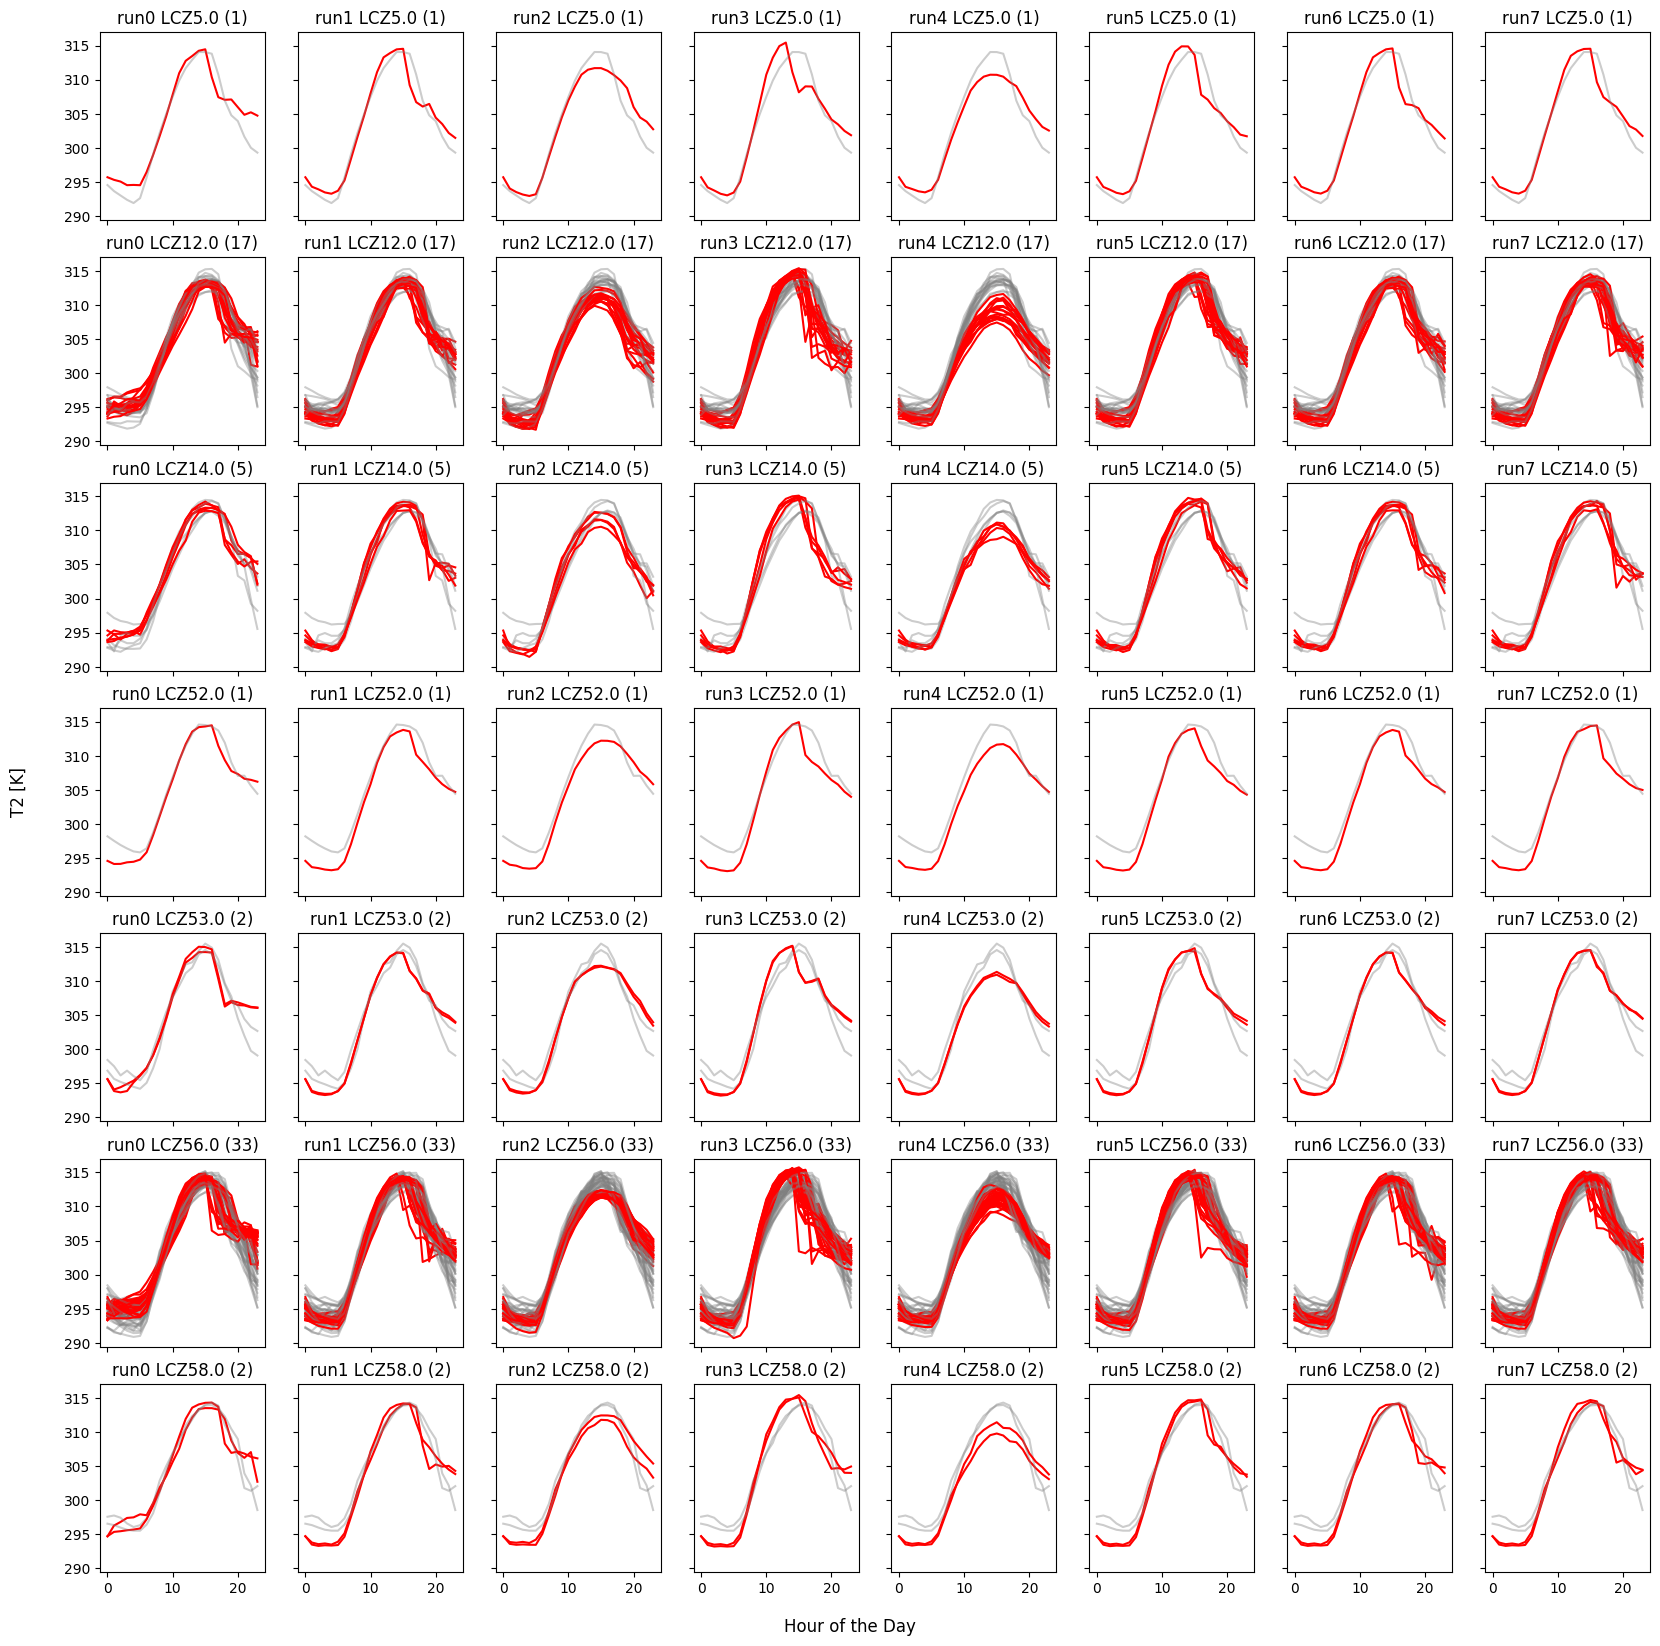

In [10]:
lczs = np.unique(obs_data_hw_lczs.LU_INDEX)
nb_rows = len(lczs)
nb_cols = len(files)

#nb_cols = 1
# nb_rows = 7
fig, axes = plt.subplots(nb_rows, nb_cols, sharex = True, sharey = True, figsize=(20,20))
fig.text(0.5, 0.08, 'Hour of the Day', ha='center', fontsize=12)
fig.text(0.08, 0.5, 'T2 [K]', va='center', rotation='vertical', fontsize=12)
k = 0
for n in np.arange(0, nb_rows):
    print(k)
    
    lcz = lczs[n]
    obs_data_hw_lcz = obs_data_hw_lczs.loc[np.where(obs_data_hw_lczs.LU_INDEX == lcz)].reset_index(drop = True)
    lcz_plot = obs_data_hw_lcz[["location", "lat", "lon", "LU_INDEX"]].drop_duplicates().reset_index(drop = True)

    for f in np.arange(0, nb_cols):
        #plt.subplot(nb_rows, nb_cols, k)
        file = files[f]
        experiment = file.split('_')[1]
        #print(experiment)
        
        ds_mod = xr.open_mfdataset(ucl_dir + 'WRF_output/' + file, combine='by_coords').rename({"XTIME": "time"})
        ds_mod.xoak.set_index(['XLAT', 'XLONG'], 'sklearn_geo_balltree')
        for s in np.arange(0, len(lcz_plot)):
            ax = axes.flat[k]
            point_coord = lcz_plot.loc[s]
            location = point_coord["lat"].astype(str) + '-' + point_coord["lon"].astype(str)
            #print(location)

            

            lat_array = xr.DataArray(np.array([point_coord.lat]), dims='point')
            lon_array = xr.DataArray(np.array([point_coord.lon]), dims='point')

            ds_mod = ds_mod.where((ds_mod.time >= start_date) & (ds_mod.time <= end_date), drop=True)
            ds_mod.xoak.set_index(['XLAT', 'XLONG'], 'sklearn_geo_balltree')
            ds_mod_point = ds_mod.xoak.sel(XLAT = lat_array, XLONG = lon_array)

            da_mod_point = ds_mod_point["T2"].compute()
            var = da_mod_point.to_dataframe(name = "T2").reset_index()
            var["hour"] = pd.to_datetime(var.time).dt.hour
            ax.plot(var.hour, var.T2, label = experiment, color = "red")
            ax.set_title(experiment + ' LCZ' + str(lcz) + ' (' + str(len(lcz_plot)) + ')')

            temp_data = obs_data_hw_lcz.loc[np.where(obs_data_hw_lcz.location == location)].reset_index(drop = True)
            for j in np.unique(temp_data.date):
                #print(j)
                temp_date = temp_data.loc[np.where(temp_data.date == j)[0]].reset_index(drop = True)
                ax.plot(temp_date.hour, temp_date.T2, color = 'grey', alpha = 0.4)

            
        k = k+1


1


ValueError: num must be an integer with 1 <= num <= 7, not 8

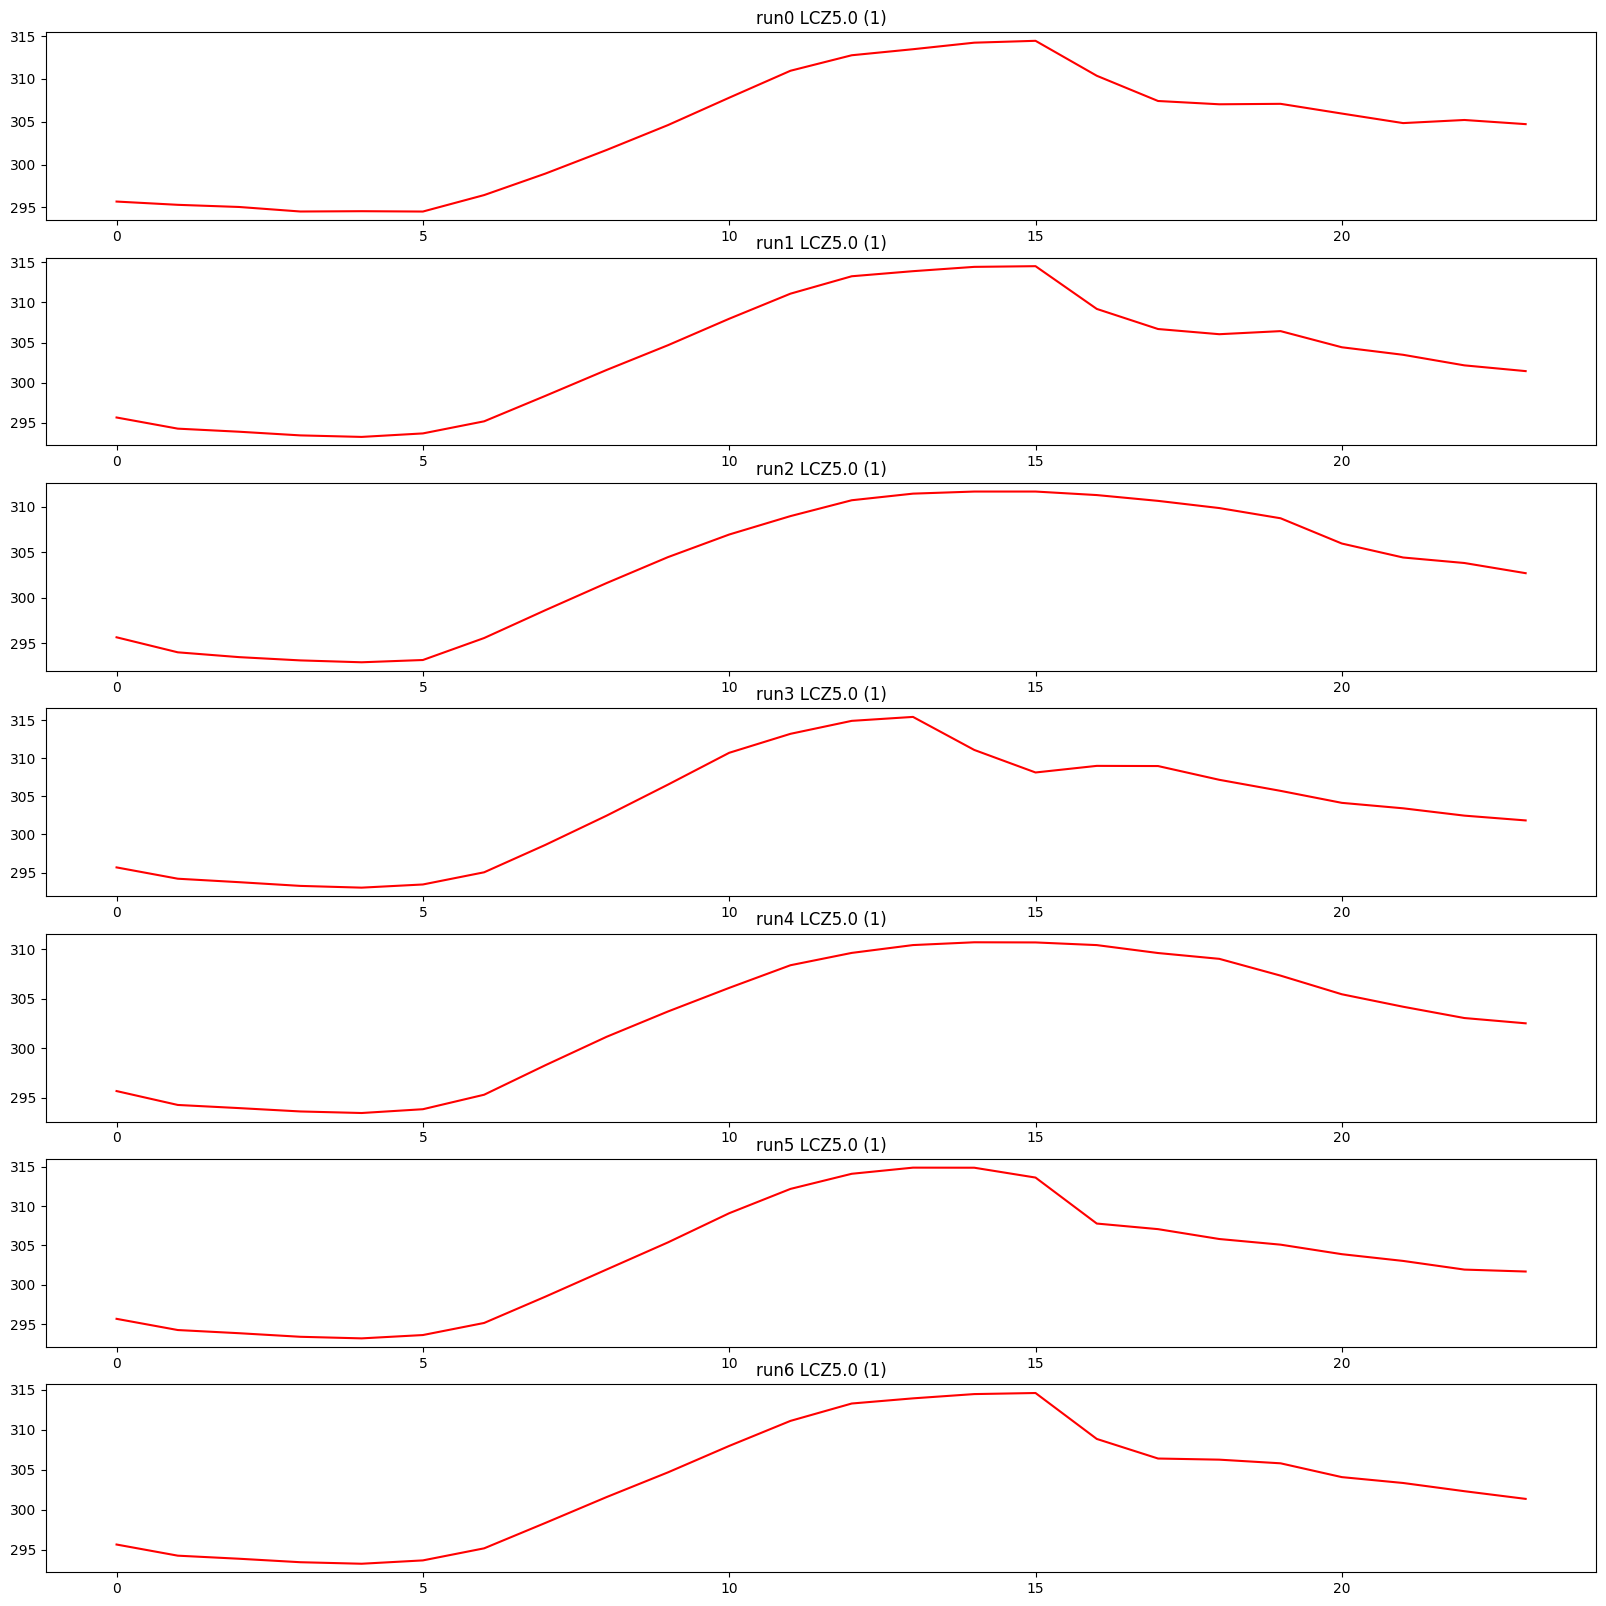

In [11]:
obs_data_hot = obs_data.loc[np.where(np.logical_and(obs_data.time >= start_date, obs_data.time <= end_date))].reset_index(drop = True)
lczs = np.unique(d_coord_points.LU_INDEX)
nb_rows = len(lczs)
nb_cols = len(files)

plt.figure(figsize=(20,20))
k = 1
for n in np.arange(0, nb_rows):
    print(k)
    lcz = lczs[n]
    #print(lcz)
    lcz_locs = d_coord_points.loc[np.where(d_coord_points.LU_INDEX == lcz)].reset_index(drop = True)
    obs_data_hw["location"] = obs_data_hw["lat"].astype(str) + '-' + obs_data_hw["lon"].astype(str)
    lcz_locs["location"] = lcz_locs["lat"].astype(str) + '-' + lcz_locs["lon"].astype(str).dropna()
    obs_data_hw_lcz = obs_data_hw.merge(lcz_locs, how= 'right', on = ["location"])

    for f in np.arange(0, nb_cols):
        plt.subplot(nb_rows, 1, k)
        file = files[f]
        experiment = file.split('_')[1]
        #print(experiment)
        
        ds_mod = xr.open_mfdataset(ucl_dir + 'WRF_output/' + file, combine='by_coords').rename({"XTIME": "time"})
        ds_mod.xoak.set_index(['XLAT', 'XLONG'], 'sklearn_geo_balltree')
        for s in np.arange(0, len(lcz_locs)):
            point_coord = lcz_locs.loc[s]
            location = point_coord["lat"].astype(str) + '-' + point_coord["lon"].astype(str)
            #print(location)
            temp_data = obs_data_hw_lcz.loc[np.where(obs_data_hw_lcz.location == location)].reset_index(drop = True)           

            lat_array = xr.DataArray(np.array([point_coord.lat]), dims='point')
            lon_array = xr.DataArray(np.array([point_coord.lon]), dims='point')

            ds_mod = ds_mod.where((ds_mod.time >= start_date) & (ds_mod.time <= end_date), drop=True)
            ds_mod.xoak.set_index(['XLAT', 'XLONG'], 'sklearn_geo_balltree')
            ds_mod_point = ds_mod.xoak.sel(XLAT = lat_array, XLONG = lon_array)

            da_mod_point = ds_mod_point["T2"].compute()
            var = da_mod_point.to_dataframe(name = "T2").reset_index()
            var["hour"] = pd.to_datetime(var.time).dt.hour
            plt.plot(var.hour, var.T2, label = experiment, color = "red")
            plt.title(experiment + ' LCZ' + str(lcz) + ' (' + str(len(lcz_locs)) + ')')

            
        k = k+1

In [ ]:

elif obs_data_str == "netatmo":
    # Loading data
    netatmo_file = ucl_dir + "netatmo_qc.csv"
    orig_data = pd.read_csv(netatmo_file)
    orig_data = orig_data.loc[np.where(orig_data.m4)]
    obs_data = orig_data.rename(columns = {"ta": "T2"})
    obs_data["T2"] = obs_data["T2"] + 273.15

    # Averaging stations that fall within same gridcell
    [obs_data_agg, obs_indices] = point_data_2_climate_grid(obs_data, ds, 'T2')

    # Converting format
    obs_data_agg.date = pd.to_datetime(obs_data_agg.time).dt.date
    obs_data = obs_data_agg.rename(columns = {"grid_index": "code"})
    obs_data['time'] = pd.to_datetime(obs_data["time"])
    obs_data["lat"] = np.round(obs_data.lat, 6)
    obs_data["lon"] = np.round(obs_data.lon, 6)

obs_data = obs_data.loc[np.where(np.logical_and(obs_data.time >= start_date, obs_data.time <= end_date))].reset_index(drop = True)

# Checking whether the stations have data for each hour
full_range = pd.date_range(start=start_date, 
                           end=end_date, 
                           freq="h")  # Hourly intervals
drop_stations = []
for c in np.unique(obs_data.code):
    code_temp = obs_data.loc[np.where(obs_data.code == c)].reset_index(drop = True)
    missing_hours = full_range.difference(code_temp["time"])
    if len(missing_hours) > 0:
        drop_stations.append(c)
#print("In " + obs_data_str + str(len(drop_stations)) " are removed.")

drop_indices = [i for i in np.arange(0, len(obs_data)) if obs_data.loc[i, "code"] in drop_stations]
obs_data = obs_data.drop(drop_indices).reset_index(drop = True)

